# Load in packages

In [162]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load in spatial dataset

In [223]:
adata = sc.read_visium('/Volumes/hqdinh2/Projects/RawData_FromUWBiotech/HNCVisium_2022-05-05/CK17-5/', genome=None, count_file='filtered_feature_bc_matrix.h5', library_id=None, load_images=True, source_image_path=None)    
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Basic pre-processing

... storing 'feature_types' as categorical
... storing 'genome' as categorical


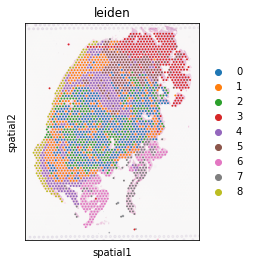

In [224]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.spatial(adata, color='leiden')

# Specifying ligand-receptor pairs

In [215]:
LR=np.array([['CXCL9', 'CXCR3', 'CXCL_pathway'],['CXCL10', 'CXCR3', 'CXCL_pathway'],['CXCL11', 'CXCR3', 'CXCL_pathway']],dtype=str)
df_ligrec = pd.DataFrame(data=LR)

# Specifying ligand-receptor pairs (CellChat database)

In [225]:
df_cellchat = ct.pp.ligand_receptor_database(species='human', database='CellChat')
print(df_cellchat.shape)

(1199, 4)


## • Filtering to only keep L-Rs that are found in at least 5% of spots

In [226]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata, min_cell_pct=0.01)
print(df_cellchat_filtered.shape)

(71, 4)


## • Printing our list of L-Rs

In [227]:
print(df_cellchat_filtered)

         0        1      2                   3
0    GDF15   TGFBR2    GDF  Secreted Signaling
1    WNT5A     FZD4  ncWNT  Secreted Signaling
2    WNT5A     MCAM  ncWNT  Secreted Signaling
3    WNT5B     FZD4  ncWNT  Secreted Signaling
4    PDGFA   PDGFRA   PDGF  Secreted Signaling
..     ...      ...    ...                 ...
66  SLURP1    CHRNE  SLURP  Secreted Signaling
67  SLURP1   CHRNA7  SLURP  Secreted Signaling
68  SLURP2   CHRNA7  SLURP  Secreted Signaling
69  SLURP2  CHRNA10  SLURP  Secreted Signaling
70  SLURP2    CHRNE  SLURP  Secreted Signaling

[71 rows x 4 columns]


# Construct CCC networks

In [228]:
ct.tl.spatial_communication(adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

#adata.write("/Volumes/hqdinh2/Projects/RawData_FromUWBiotech/HNCVisium_2022-05-05/CK17-5_analysis/COMMOT.h5ad")

# Determine communication direction

In [220]:
adata.obsp

PairwiseArrays with keys: distances, connectivities, commot-cellchat-CXCL8-ACKR1, commot-cellchat-SLURP1-CHRND, commot-cellchat-CCL18-ACKR1, commot-cellchat-CCL14-ACKR1, commot-cellchat-CCL, commot-cellchat-CXCL, commot-cellchat-SLURP, commot-cellchat-total-total

In [221]:
adata.obsm

AxisArrays with keys: spatial, X_pca, X_umap, commot-cellchat-sum-sender, commot-cellchat-sum-receiver

<AxesSubplot:>

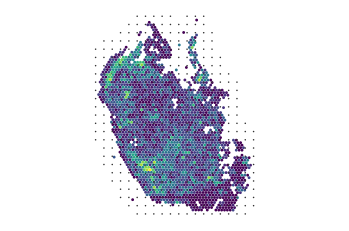

In [230]:
adata = ct.tl.communication_direction(adata, database_name='cellchat', pathway_name = 'CXCL', k=5, copy = True)
ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name = 'CXCL', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='summary', clustering='BayesSpace', cmap='viridis',
    normalize_v = True, normalize_v_quantile=0.995)

# Visium test

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


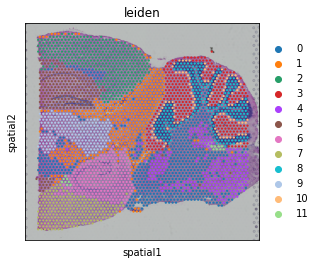

(1209, 4)
(250, 4)


In [96]:
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata_dis500 = adata.copy()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.spatial(adata, color='leiden')
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

<AxesSubplot:>

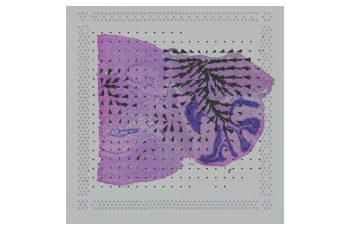

In [100]:
ct.tl.communication_direction(adata_dis500, database_name='cellchat', pathway_name='PSAP', k=5)
ct.pl.plot_cell_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)
